In [1]:
import ccxt
import pandas as pd

Definisco l'exchange di riferimento sfruttando la libreria ccxt ed esploro successivamente i mercati, identificando gli strumenti e le coppie di simboli su cui si può operare 

In [2]:
exchange = ccxt.bybit()

In [3]:
markets = pd.DataFrame(exchange.fetch_markets())

Esploro una riga esemplificativa e appunto dati che possono tornarmi utili sia in fase di analisi che in fase operativa come type (tipologia di strumento), taker e maker (commissioni), precision (amount e prezzi specifici per lo strumento), limits (minimi e massimi di leva, amount e prezzo).

In [4]:
markets.iloc[0]

id                                                          BTCUSDT
lowercaseId                                                    None
symbol                                                     BTC/USDT
base                                                            BTC
quote                                                          USDT
settle                                                         None
baseId                                                          BTC
quoteId                                                        USDT
settleId                                                       None
type                                                           spot
spot                                                           True
margin                                                         True
swap                                                          False
future                                                        False
option                                          

Dopo aver compreso quali e quante tipologie di strumenti sono disponibili sull'Exchange di riferimento, li suddivido in due serie in base a quelli su cui penso di operare 

In [5]:
types = markets.value_counts('type')

In [6]:
types

type
option    1500
spot       570
swap       402
future      20
Name: count, dtype: int64

In [7]:
spot_symbols = markets.loc[markets['type'] == 'spot', 'symbol']
swap_symbols = markets.loc[(markets['type'] == 'swap')&(markets['quoteId'] == 'USDT'), 'symbol']

In [8]:
spot_symbols

0         BTC/USDT
1         ETH/USDT
2         XRP/USDT
3         EOS/USDT
4          ETH/BTC
          ...     
565       MOG/USDT
566     TAIKO/USDT
567      ULTI/USDT
568    AURORA/USDT
569      AARK/USDT
Name: symbol, Length: 570, dtype: object

In [9]:
swap_symbols

570    10000000AIDOGE/USDT:USDT
571        1000000MOG/USDT:USDT
572          10000COQ/USDT:USDT
573        10000LADYS/USDT:USDT
574          10000NFT/USDT:USDT
                 ...           
974              ZETA/USDT:USDT
975              ZEUS/USDT:USDT
976               ZIL/USDT:USDT
977               ZKF/USDT:USDT
978               ZRX/USDT:USDT
Name: symbol, Length: 370, dtype: object

Dopo aver esplorato gli strumenti (che potranno successivamente essere modificati in base a nuove necessità), passiamo all'esplorazione delle serie temporali di ognuno di loro. Usiamo la funzione **fetch_ohlcv** per recuperare le ultime x candele di ogni strumento. Le candele ohlcv rappresentano i prezzi di apertura, i massimi, i minimi, di chiusura e il volume degli scambi di un determinato asset in un timeframe specifico. Perciò inseriamo tutti i dati in un dataframe di pandas. 


In [10]:
candlesticks = pd.DataFrame()
for symbol in swap_symbols:
    data = exchange.fetch_ohlcv(symbol,limit=1000,timeframe='1m')
    data_df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    #data_df['timestamp'] = pd.to_datetime(data_df['timestamp_ms'], unit='ms') 
    data_df['symbol'] = symbol
    candlesticks = pd.concat([candlesticks, data_df])
    

KeyboardInterrupt: 

In [14]:
candlesticks

,timestamp,open,high,low,close,volume,symbol
0,1706592660000,0.014670,0.014670,0.014662,0.014662,3700.0,1000000VINU/USDT:USDT
1,1706592720000,0.014662,0.014673,0.014658,0.014673,6500.0,1000000VINU/USDT:USDT
2,1706592780000,0.014673,0.014680,0.014669,0.014680,11900.0,1000000VINU/USDT:USDT
3,1706592840000,0.014680,0.014710,0.014680,0.014698,79300.0,1000000VINU/USDT:USDT
4,1706592900000,0.014698,0.014698,0.014697,0.014698,20600.0,1000000VINU/USDT:USDT
...,...,...,...,...,...,...,...
995,1706652480000,0.336600,0.336600,0.336300,0.336300,1833.0,ZRX/USDT:USDT
996,1706652540000,0.336300,0.336300,0.335800,0.335900,4211.0,ZRX/USDT:USDT
997,1706652600000,0.335900,0.336200,0.335900,0.336000,418.0,ZRX/USDT:USDT
998,1706652660000,0.336000,0.336000,0.335800,0.335800,479.0,ZRX/USDT:USDT


In [15]:
single_symbol = candlesticks.query('symbol == "BTC/USDT:USDT"')

In [16]:
single_symbol['timestamp'] = pd.to_datetime(single_symbol['timestamp'], unit='ms')



C:\Users\antci\AppData\Local\Temp\ipykernel_19204\1724774311.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_symbol['timestamp'] = pd.to_datetime(single_symbol['timestamp'], unit='ms')


Il dataset comincia a prendere forma ma abbiamo bisogno di ulteriori dati per poter individuare i trend in atto o le inversioni di tendenza. Per fare questo ci aiuteremo con la libreria **TA-Lib** che ci permette di applicare ai nostri dati finanziari una serie di indicatori di Analisi Tecnica, e con alcune funzioni che aggiungeremo contestualmente, come quella del calcolo della volatilità che, come da prassi, viene calcolata con i rendimenti logaritmici dei prezzi di chiusura

In [17]:
import numpy as np
import talib

In [18]:
def calculate_volatility(df,window=60):
    df.loc[:,'returns'] = np.log(df['close'] / df['close'].shift(1))
    df.loc[:,f'volatility{window}'] = df['returns'].rolling(window).std() * ((60) ** 0.5)
    return df

In [19]:
calculate_volatility(single_symbol, window=60)
calculate_volatility(single_symbol, window=30)
calculate_volatility(single_symbol, window=15)
calculate_volatility(single_symbol, window=5)

C:\Users\antci\AppData\Local\Temp\ipykernel_19204\61727006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'returns'] = np.log(df['close'] / df['close'].shift(1))
C:\Users\antci\AppData\Local\Temp\ipykernel_19204\61727006.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,f'volatility{window}'] = df['returns'].rolling(window).std() * ((60) ** 0.5)
C:\Users\antci\AppData\Local\Temp\ipykernel_19204\61727006.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

,timestamp,open,high,low,close,volume,symbol,returns,volatility60,volatility30,volatility15,volatility5
0,2024-01-30 05:32:00,43354.1,43354.8,43335.6,43354.0,83.677,BTC/USDT:USDT,NaN,NaN,NaN,NaN,NaN
1,2024-01-30 05:33:00,43354.0,43355.0,43353.9,43355.0,27.142,BTC/USDT:USDT,0.000023,NaN,NaN,NaN,NaN
2,2024-01-30 05:34:00,43355.0,43381.1,43354.9,43380.0,35.129,BTC/USDT:USDT,0.000576,NaN,NaN,NaN,NaN
3,2024-01-30 05:35:00,43380.0,43381.9,43379.9,43381.9,6.584,BTC/USDT:USDT,0.000044,NaN,NaN,NaN,NaN
4,2024-01-30 05:36:00,43381.9,43382.0,43378.7,43379.1,21.824,BTC/USDT:USDT,-0.000065,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
995,2024-01-30 22:07:00,43526.0,43539.0,43524.5,43538.9,26.775,BTC/USDT:USDT,0.000296,0.003166,0.002550,0.002278,0.001536
996,2024-01-30 22:08:00,43538.9,43540.0,43515.8,43515.8,14.402,BTC/USDT:USDT,-0.000531,0.003212,0.002624,0.002500,0.002924
997,2024-01-30 22:09:00,43515.8,43515.8,43465.0,43473.5,100.632,BTC/USDT:USDT,-0.000973,0.003343,0.002752,0.003112,0.004629
998,2024-01-30 22:10:00,43473.5,43484.0,43470.1,43483.9,27.209,BTC/USDT:USDT,0.000239,0.003061,0.002765,0.003177,0.004774


In [20]:
def calculate_sma(df, window):
    df.loc[:,f'sma_{window}'] = talib.SMA(df['close'], timeperiod=window)
    return df

In [21]:
def calculate_ema(df, window):
    df.loc[:,f'ema_{window}'] = talib.EMA(df['close'], timeperiod=window)
    return df

In [22]:
def calculate_wma(df, window):
    df.loc[:,f'wma_{window}'] = talib.WMA(df['close'], timeperiod=window)
    return df

In [23]:
periods = [5, 10, 21, 50, 100, 200]

In [24]:
for p in periods:
    calculate_sma(single_symbol,p)
    calculate_wma(single_symbol,p)
    calculate_ema(single_symbol,p)

C:\Users\antci\AppData\Local\Temp\ipykernel_19204\3204828637.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,f'sma_{window}'] = talib.SMA(df['close'], timeperiod=window)
C:\Users\antci\AppData\Local\Temp\ipykernel_19204\208410604.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,f'wma_{window}'] = talib.WMA(df['close'], timeperiod=window)
C:\Users\antci\AppData\Local\Temp\ipykernel_19204\3909666156.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [25]:
single_symbol.loc[:,'rsi'] = talib.RSI(single_symbol['close'])
single_symbol.loc[:,'rsi_sma'] = talib.SMA(single_symbol['rsi'],timeperiod=14)
single_symbol.loc[:,'adx'] = talib.ADX(single_symbol['high'], single_symbol['low'], single_symbol['close'], timeperiod=14)
single_symbol.loc[:,'macd'], single_symbol.loc[:,'macdsignal'], single_symbol.loc[:,'macdhist'] = talib.MACD(single_symbol['close'], fastperiod=12, slowperiod=26, signalperiod=9)
single_symbol.loc[:,'macd_fix'], single_symbol.loc[:,'macdsignal_fix'], single_symbol.loc[:,'macdhist_fix'] = talib.MACDFIX(single_symbol['close'], signalperiod=9)
single_symbol.loc[:,'ppo'] = talib.PPO(single_symbol['close'], fastperiod=12, slowperiod=26, matype=0)
single_symbol.loc[:,'roc'] = talib.ROC(single_symbol['close'], timeperiod=10)
single_symbol.loc[:,'rocp'] = talib.ROCP(single_symbol['close'], timeperiod=10)
single_symbol.loc[:,'rocr'] = talib.ROCR(single_symbol['close'], timeperiod=10)
single_symbol.loc[:,'slowk'], single_symbol.loc[:,'slowd'] = talib.STOCH(single_symbol['high'], single_symbol['low'], single_symbol['close'], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
single_symbol.loc[:,'ultosc'] = talib.ULTOSC(single_symbol['high'], single_symbol['low'], single_symbol['close'], timeperiod1=7, timeperiod2=14, timeperiod3=28)
single_symbol.loc[:,'willr'] = talib.WILLR(single_symbol['high'], single_symbol['low'], single_symbol['close'], timeperiod=14)

C:\Users\antci\AppData\Local\Temp\ipykernel_19204\3691094708.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_symbol.loc[:,'rsi'] = talib.RSI(single_symbol['close'])
C:\Users\antci\AppData\Local\Temp\ipykernel_19204\3691094708.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_symbol.loc[:,'rsi_sma'] = talib.SMA(single_symbol['rsi'],timeperiod=14)
C:\Users\antci\AppData\Local\Temp\ipykernel_19204\3691094708.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [26]:
single_symbol.loc[:,'upperband'], single_symbol.loc[:,'middleband'], single_symbol.loc[:,'lowerband'] = talib.BBANDS(single_symbol['close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
single_symbol.loc[:,'sar'] = talib.SAR(single_symbol['high'], single_symbol['low'], acceleration=0.02, maximum=0.2)
single_symbol.loc[:,'correl'] = talib.CORREL(single_symbol['high'], single_symbol['low'], timeperiod=30)
single_symbol.loc[:,'linearreg'] = talib.LINEARREG(single_symbol['close'], timeperiod=14)
single_symbol.loc[:,'linearreg_angle'] = talib.LINEARREG_ANGLE(single_symbol['close'], timeperiod=14)
single_symbol.loc[:,'linearreg_intercept'] = talib.LINEARREG_INTERCEPT(single_symbol['close'], timeperiod=14)
single_symbol.loc[:,'linearreg_slope'] = talib.LINEARREG_SLOPE(single_symbol['close'], timeperiod=14)
single_symbol.loc[:,'stddev'] = talib.STDDEV(single_symbol['close'], timeperiod=5, nbdev=1)
single_symbol.loc[:,'tsf'] = talib.TSF(single_symbol['close'], timeperiod=14)
single_symbol.loc[:,'var'] = talib.VAR(single_symbol['close'], timeperiod=5, nbdev=1)

C:\Users\antci\AppData\Local\Temp\ipykernel_19204\643732087.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_symbol.loc[:,'upperband'], single_symbol.loc[:,'middleband'], single_symbol.loc[:,'lowerband'] = talib.BBANDS(single_symbol['close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
C:\Users\antci\AppData\Local\Temp\ipykernel_19204\643732087.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_symbol.loc[:,'upperband'], single_symbol.loc[:,'middleband'], single_symbol.loc[:,'lowerband']

In [27]:
single_symbol.loc[:,'atr'] = talib.ATR(single_symbol['high'], single_symbol['low'], single_symbol['close'], timeperiod=14)
single_symbol.loc[:,'tr'] = talib.TRANGE(single_symbol['high'], single_symbol['low'], single_symbol['close'])
single_symbol.loc[:,'ad'] = talib.AD(single_symbol['high'], single_symbol['low'], single_symbol['close'], single_symbol['volume'])
single_symbol.loc[:,'adosc'] = talib.ADOSC(single_symbol['high'], single_symbol['low'], single_symbol['close'], single_symbol['volume'], fastperiod=3, slowperiod=10)
single_symbol.loc[:,'obv'] = talib.OBV(single_symbol['close'], single_symbol['volume'])
single_symbol.loc[:,'mama'], single_symbol.loc[:,'fama'] = talib.MAMA(single_symbol['close'], fastlimit=0.5, slowlimit=0.05)
single_symbol.loc[:,'htdcperiod'] = talib.HT_DCPERIOD(single_symbol['close'])
single_symbol.loc[:,'htdcphase'] = talib.HT_DCPHASE(single_symbol['close'])
single_symbol.loc[:,'inphase'], single_symbol.loc[:,'quadrature'] = talib.HT_PHASOR(single_symbol['close'])
single_symbol.loc[:,'sine'], single_symbol.loc[:,'leadsine'] = talib.HT_SINE(single_symbol['close'])
single_symbol.loc[:,'trendmode'] = talib.HT_TRENDMODE(single_symbol['close'])


C:\Users\antci\AppData\Local\Temp\ipykernel_19204\1695117974.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_symbol.loc[:,'atr'] = talib.ATR(single_symbol['high'], single_symbol['low'], single_symbol['close'], timeperiod=14)
C:\Users\antci\AppData\Local\Temp\ipykernel_19204\1695117974.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_symbol.loc[:,'tr'] = talib.TRANGE(single_symbol['high'], single_symbol['low'], single_symbol['close'])
C:\Users\antci\AppData\Local\Temp\ipykernel_19204\169

In [28]:
single_symbol.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'symbol',
       'returns', 'volatility60', 'volatility30', 'volatility15',
       'volatility5', 'sma_5', 'wma_5', 'ema_5', 'sma_10', 'wma_10', 'ema_10',
       'sma_21', 'wma_21', 'ema_21', 'sma_50', 'wma_50', 'ema_50', 'sma_100',
       'wma_100', 'ema_100', 'sma_200', 'wma_200', 'ema_200', 'rsi', 'rsi_sma',
       'adx', 'macd', 'macdsignal', 'macdhist', 'macd_fix', 'macdsignal_fix',
       'macdhist_fix', 'ppo', 'roc', 'rocp', 'rocr', 'slowk', 'slowd',
       'ultosc', 'willr', 'upperband', 'middleband', 'lowerband', 'sar',
       'correl', 'linearreg', 'linearreg_angle', 'linearreg_intercept',
       'linearreg_slope', 'stddev', 'tsf', 'var', 'atr', 'tr', 'ad', 'adosc',
       'obv', 'mama', 'fama', 'htdcperiod', 'htdcphase', 'inphase',
       'quadrature', 'sine', 'leadsine', 'trendmode'],
      dtype='object')

In [29]:
single_symbol['sar'].describe()

count      999.000000
mean     43403.727510
std        119.080263
min      43083.700000
25%      43334.328083
50%      43396.856000
75%      43463.704034
max      43890.800000
Name: sar, dtype: float64

In [30]:
single_symbol.dropna(inplace=True)

C:\Users\antci\AppData\Local\Temp\ipykernel_19204\1266416572.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_symbol.dropna(inplace=True)


In [31]:
single_symbol.describe()

,timestamp,open,high,low,close,volume,returns,volatility60,volatility30,volatility15,...,obv,mama,fama,htdcperiod,htdcphase,inphase,quadrature,sine,leadsine,trendmode
count,801,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,2024-01-30 15:31:00.000000256,43415.679775,43431.663546,43399.356055,43415.823346,90.811594,0.000003,0.004708,0.004637,0.004562,...,-228.350102,43416.424635,43416.373816,21.812975,127.991465,0.681459,0.308496,0.017384,-0.057184,0.476904
min,2024-01-30 08:51:00,43091.800000,43129.100000,43083.700000,43091.800000,0.000000,-0.004838,0.002261,0.002070,0.001443,...,-2285.435000,43144.494757,43196.372252,13.551696,-44.371985,-245.280014,-213.442707,-1.000000,-0.999955,0.000000
25%,2024-01-30 12:11:00,43344.500000,43360.000000,43333.200000,43344.500000,24.849000,-0.000310,0.003203,0.003234,0.003138,...,-664.798000,43354.010616,43359.944195,18.371418,31.764572,-19.964337,-32.247376,-0.483176,-0.823764,0.000000
50%,2024-01-30 15:31:00,43405.600000,43420.000000,43390.400000,43405.600000,50.345000,0.000023,0.004504,0.004368,0.004113,...,-54.253000,43401.443319,43394.959112,21.375808,150.454943,2.314623,2.221103,0.005916,-0.212408,0.000000
75%,2024-01-30 18:51:00,43486.900000,43505.800000,43477.400000,43486.900000,96.541000,0.000346,0.005682,0.005571,0.005639,...,479.847000,43490.569766,43481.968696,23.997502,201.718912,23.959449,33.589217,0.511385,0.750197,1.000000
max,2024-01-30 22:11:00,43837.000000,43890.800000,43761.100000,43837.000000,1784.684000,0.002613,0.009387,0.011640,0.014101,...,2208.193000,43711.239326,43651.765953,37.653586,314.430366,141.362567,277.212704,0.999982,0.999998,1.000000
std,NaN,116.161162,116.887146,115.827470,116.174339,140.177743,0.000640,0.001620,0.001838,0.002052,...,993.927364,108.899371,100.080857,4.869888,96.002133,39.904748,59.253999,0.599455,0.758611,0.499778


Proviamo già con questi dati a fare una primissima analisi di relazione tra le variabili. Sfruttiamo seaborn per una visualizzazione grafica delle stesse

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

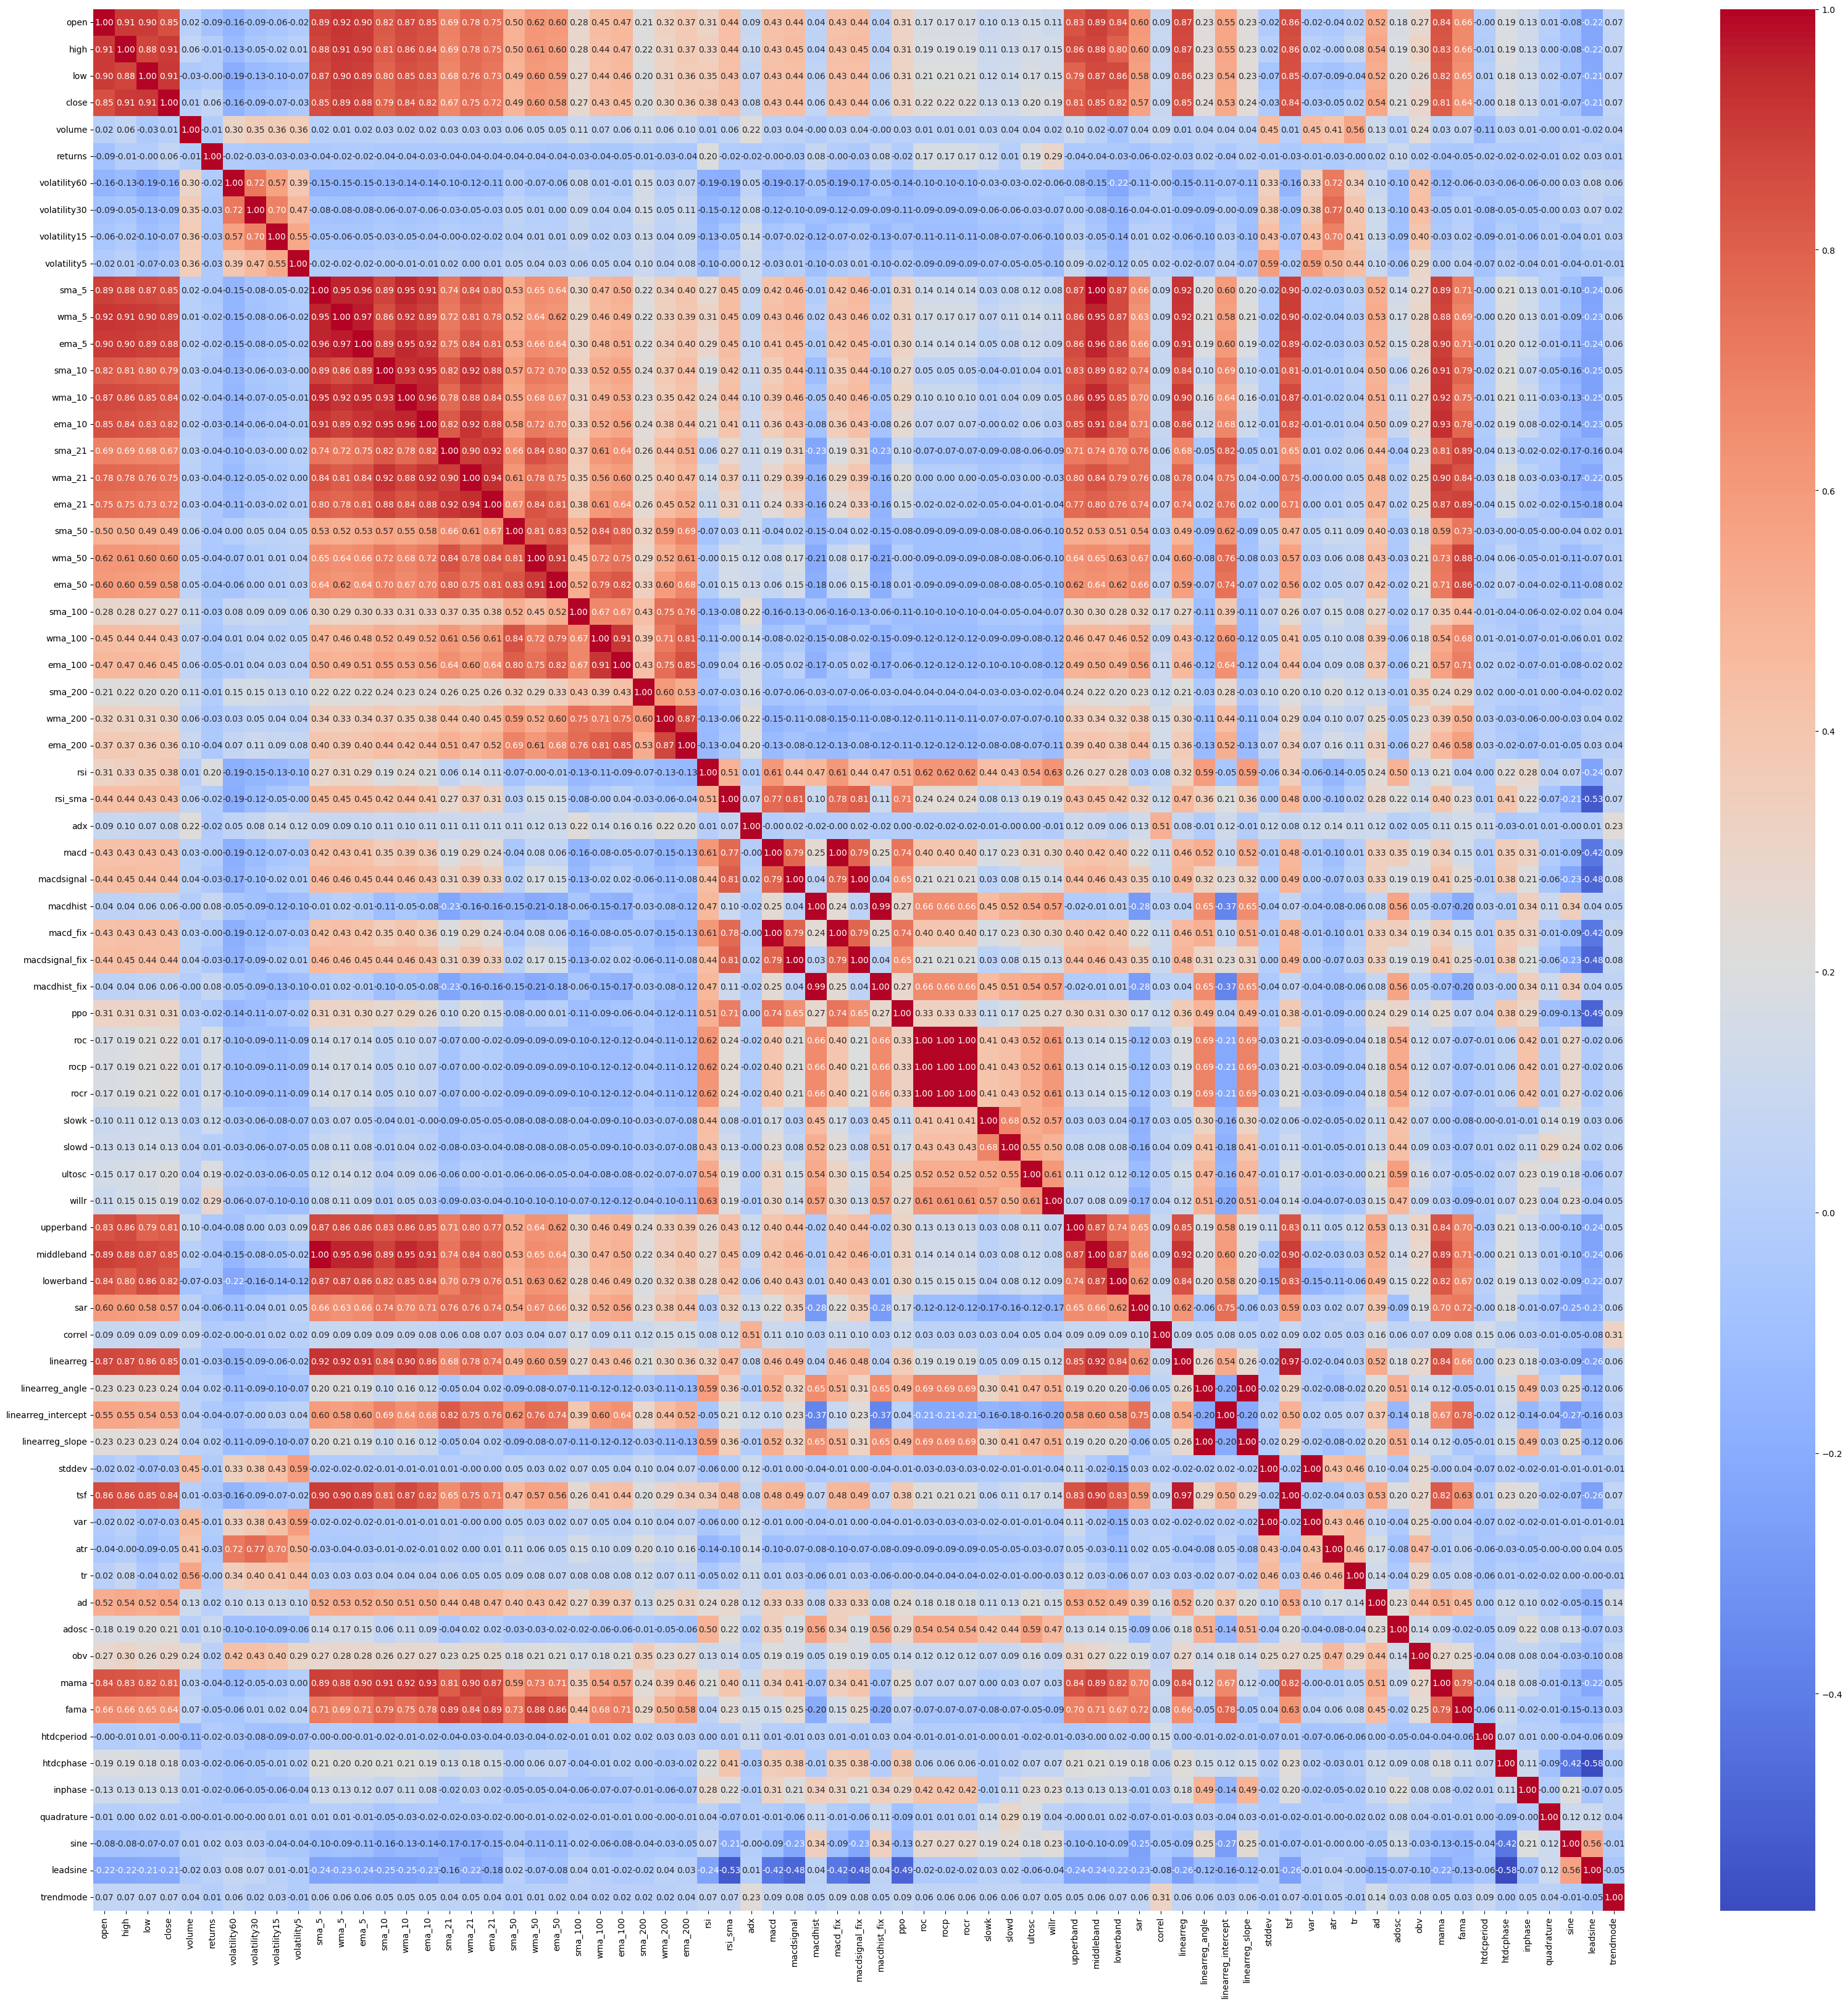

In [33]:
plt.figure(figsize=(40,40))
sns.heatmap(single_symbol.corr('kendall',numeric_only=True),annot=True,cmap=sns.color_palette("coolwarm", as_cmap=True),fmt='.2f')



<Figure size 2000x2000 with 0 Axes>

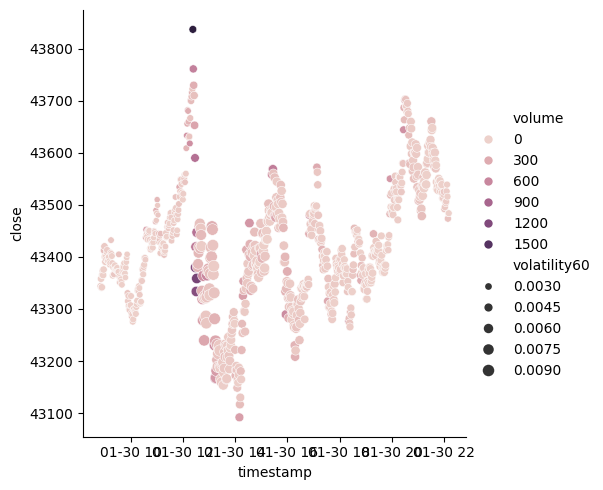

In [34]:
plt.figure(figsize=(20,20))
sns.relplot(data=single_symbol,x='timestamp',y='close',size='volatility60', hue='volume')

Con questi relplot fatti per caso si può notare che i campioni posti agli estremi dei movimenti di Rsi nel tempo sono più grossi di quelli centrali. Questo può essere interessante dal punto di vista della ricerca alle inversioni di tendenza. 
- Si potrebbero confrontare più grafici possibili e più timeframe possibili
- Ci si potrebbero porre nuove diverse domande come : in che modo cambiano i volumi nel tempo? come quantificare queste variazioni?

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


In [53]:
X = single_symbol.drop(['timestamp','open','high','low','close','symbol'], axis=1)
y = single_symbol['close']


In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [64]:
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)


DecisionTreeRegressor(random_state=42)

In [65]:
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Errore Quadratico Medio: ", mse)


Errore Quadratico Medio:  667.3668322981281


In [57]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)


In [58]:
r2

0.9589837700621787

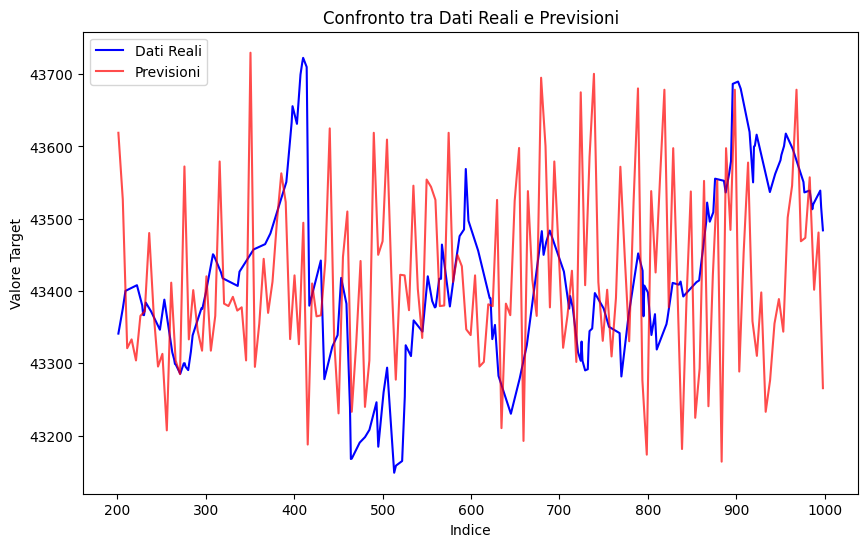

In [97]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Dati Reali', color='blue')
plt.plot(indice_pred, y_pred, label='Previsioni', color='red', alpha=0.7)
plt.title('Confronto tra Dati Reali e Previsioni')
plt.xlabel('Indice')
plt.ylabel('Valore Target')
plt.legend()
plt.show()


In [93]:
y_test = y_test.sort_index()
indice_pred = np.linspace(start=y_test.index.min(), stop=y_test.index.max(), num=len(y_pred))


In [96]:
indice_pred

array([201.     , 205.98125, 210.9625 , 215.94375, 220.925  , 225.90625,
       230.8875 , 235.86875, 240.85   , 245.83125, 250.8125 , 255.79375,
       260.775  , 265.75625, 270.7375 , 275.71875, 280.7    , 285.68125,
       290.6625 , 295.64375, 300.625  , 305.60625, 310.5875 , 315.56875,
       320.55   , 325.53125, 330.5125 , 335.49375, 340.475  , 345.45625,
       350.4375 , 355.41875, 360.4    , 365.38125, 370.3625 , 375.34375,
       380.325  , 385.30625, 390.2875 , 395.26875, 400.25   , 405.23125,
       410.2125 , 415.19375, 420.175  , 425.15625, 430.1375 , 435.11875,
       440.1    , 445.08125, 450.0625 , 455.04375, 460.025  , 465.00625,
       469.9875 , 474.96875, 479.95   , 484.93125, 489.9125 , 494.89375,
       499.875  , 504.85625, 509.8375 , 514.81875, 519.8    , 524.78125,
       529.7625 , 534.74375, 539.725  , 544.70625, 549.6875 , 554.66875,
       559.65   , 564.63125, 569.6125 , 574.59375, 579.575  , 584.55625,
       589.5375 , 594.51875, 599.5    , 604.48125, 